
## Lab Assignment 04 

**Dataset:** Intel Image Classification (Natural Scenes)  
**Categories:** buildings, forest, glacier, mountain, sea, street  
**Dataset Link:** https://www.kaggle.com/datasets/puneet6060/intel-image-classification


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


## config

In [2]:
# Configuration
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# Class names
CLASS_NAMES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
NUM_CLASSES = len(CLASS_NAMES)

# Dataset paths (adjust according to your setup)
TRAIN_DIR = 'seg_train/seg_train'
TEST_DIR = 'seg_test/seg_test'
PRED_DIR = 'seg_pred/seg_pred'

print(f"Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Class Names: {CLASS_NAMES}")

Image Size: 150x150
Batch Size: 32
Number of Classes: 6
Class Names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## q1: Dataset Overview

Visualize samples from the dataset and display statistics.

In [3]:
# Dataset statistics
print("Dataset Statistics:")
print("=" * 60)

for dataset_name, dataset_path in [('Training', TRAIN_DIR), ('Testing', TEST_DIR)]:
    print(f"\n{dataset_name} Set:")
    total_images = 0
    for class_name in CLASS_NAMES:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            num_images = len([f for f in os.listdir(class_path) 
                             if f.endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  {class_name}: {num_images} images")
            total_images += num_images
    print(f"  Total: {total_images} images")

Dataset Statistics:

Training Set:
  buildings: 2191 images
  forest: 2271 images
  glacier: 2404 images
  mountain: 2512 images
  sea: 2274 images
  street: 2382 images
  Total: 14034 images

Testing Set:
  buildings: 437 images
  forest: 474 images
  glacier: 553 images
  mountain: 525 images
  sea: 510 images
  street: 501 images
  Total: 3000 images


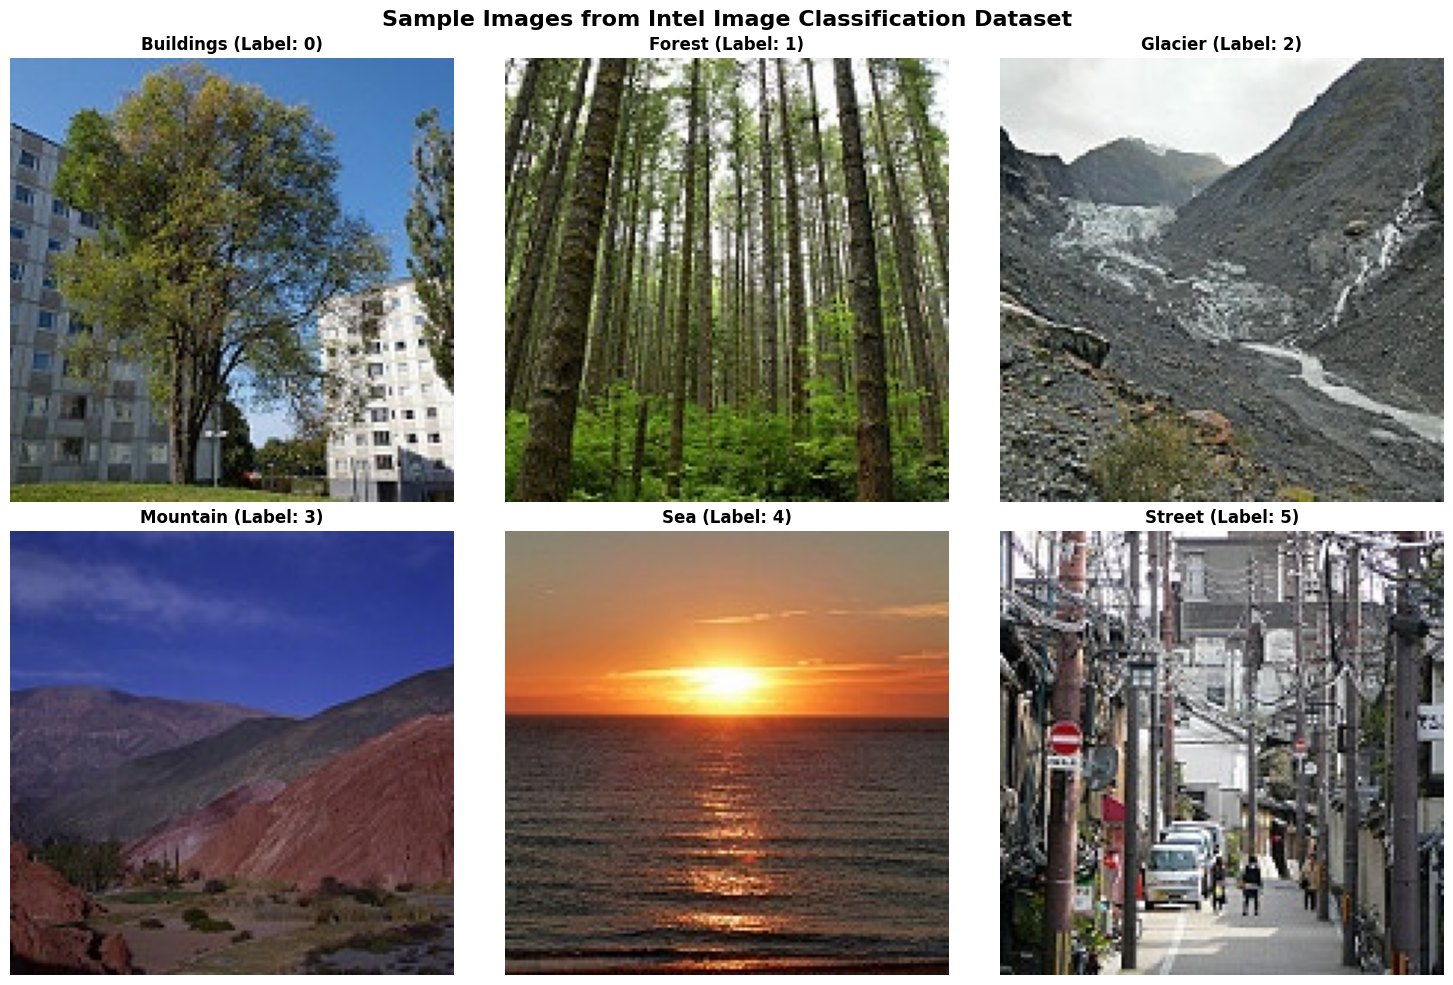

In [4]:
# Visualize sample images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sample Images from Intel Image Classification Dataset', 
             fontsize=16, fontweight='bold')

for idx, class_name in enumerate(CLASS_NAMES):
    row = idx // 3
    col = idx % 3
    
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) 
                 if f.endswith(('.jpg', '.jpeg', '.png'))]
        if images:
            img_path = os.path.join(class_path, np.random.choice(images))
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'{class_name.capitalize()} (Label: {idx})', 
                                    fontsize=12, fontweight='bold')
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## q3 & q5: Data Preparation with Augmentation

In [5]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # Random rotation
    width_shift_range=0.2,      # Random horizontal shift
    height_shift_range=0.2,     # Random vertical shift
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest',
    validation_split=0.2         # 20% for validation
)

# Test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Training samples: 11230
Validation samples: 2804
Test samples: 3000


## q2: CNN Model Architecture

Design CNN with:
- Multiple convolutional layers
- Batch normalization
- Dropout
- Pooling layers

In [6]:
# Build CNN Model
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(64, (3, 3), padding='same', 
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Third Convolutional Block
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Fourth Convolutional Block
    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    # Output Layer
    layers.Dense(NUM_CLASSES, activation='softmax')
])

print("Model Architecture:")
model.summary()

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 37, 37, 256)    │             

 Total params: 26,063,174 (99.42 MB)

 Trainable params: 26,057,798 (99.40 MB)

 Non-trainable params: 5,376 (21.00 KB)

## q3: Model Compilation

In [7]:
# Compile model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (learning_rate={LEARNING_RATE})")
print(f"Loss function: categorical_crossentropy")

Model compiled successfully!
Optimizer: Adam (learning_rate=0.001)
Loss function: categorical_crossentropy


##  q3: Model Training

In [8]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

print(f"Training for {EPOCHS} epochs...")
print("Callbacks: Early Stopping, Learning Rate Reduction, Model Checkpoint")

Training for 10 epochs...
Callbacks: Early Stopping, Learning Rate Reduction, Model Checkpoint


In [9]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4614 - loss: 1.4290
Epoch 1: val_accuracy improved from None to 0.37803, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 1174s 3s/step - accuracy: 0.5263 - loss: 1.2217 - val_accuracy: 0.3780 - val_loss: 1.9713 - learning_rate: 0.0010
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6322 - loss: 0.9743
Epoch 2: val_accuracy improved from 0.37803 to 0.65585, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 1148s 3s/step - accuracy: 0.6437 - loss: 0.9459 - val_accuracy: 0.6558 - val_loss: 0.8815 - learning_rate: 0.0010
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6840 - loss: 0.8500
Epoch 3: val_accuracy did not improve from 0.65585
351/351 ━━━━━━━━━━━━━━━━━━━━ 1106s 3s/step - accuracy: 0.6908 - loss: 0.8290 - val_accuracy: 0.5481 - val_loss: 1.3461 - learning_rate: 0.0010
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7168 - loss: 0.7829
Epoch 4: val_accuracy improved from 0.65585 to 0.71755, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 1191s 3s/step - accuracy: 0.7295 - loss: 0.7525 - val_accuracy: 0.7175 - val_loss: 0.7634 - learning_rate: 0.0010
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7426 - loss: 0.6935
Epoch 5: val_accuracy improved from 0.71755 to 0.74251, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 1359s 4s/step - accuracy: 0.7476 - loss: 0.6820 - val_accuracy: 0.7425 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7659 - loss: 0.6557
Epoch 6: val_accuracy did not improve from 0.74251
351/351 ━━━━━━━━━━━━━━━━━━━━ 1118s 3s/step - accuracy: 0.7667 - loss: 0.6483 - val_accuracy: 0.7101 - val_loss: 0.7983 - learning_rate: 0.0010
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7749 - loss: 0.6162
Epoch 7: val_accuracy improved from 0.74251 to 0.74822, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 1250s 4s/step - accuracy: 0.7742 - loss: 0.6202 - val_accuracy: 0.7482 - val_loss: 0.6816 - learning_rate: 0.0010
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7804 - loss: 0.6041
Epoch 8: val_accuracy improved from 0.74822 to 0.79993, saving model to best_model.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 1514s 4s/step - accuracy: 0.7851 - loss: 0.5937 - val_accuracy: 0.7999 - val_loss: 0.5497 - learning_rate: 0.0010
Epoch 9/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8042 - loss: 0.5501
Epoch 9: val_accuracy did not improve from 0.79993
351/351 ━━━━━━━━━━━━━━━━━━━━ 1445s 4s/step - accuracy: 0.7988 - loss: 0.5634 - val_accuracy: 0.7479 - val_loss: 0.6991 - learning_rate: 0.0010
Epoch 10/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8119 - loss: 0.5295
Epoch 10: val_accuracy did not improve from 0.79993
351/351 ━━━━━━━━━━━━━━━━━━━━ 1331s 4s/step - accuracy: 0.8123 - loss: 0.5292 - val_accuracy: 0.5699 - val_loss: 1.4200 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 8.

Training completed!


## q4: Training Visualization

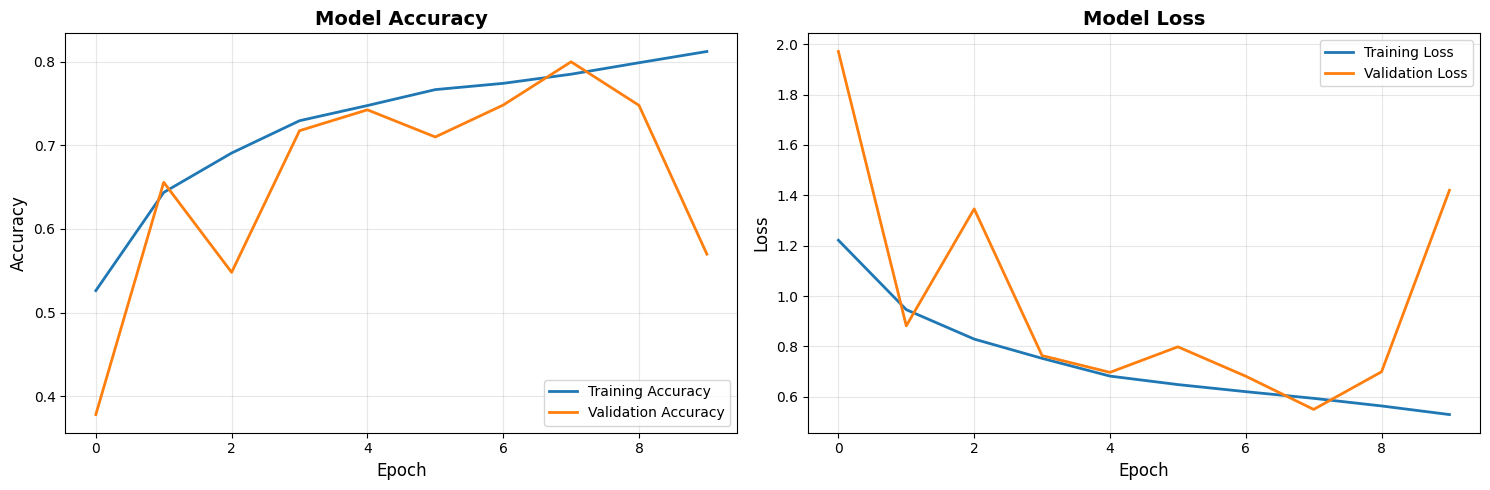


Final Training Metrics:
Training Accuracy: 0.8123
Validation Accuracy: 0.5699
Training Loss: 0.5292
Validation Loss: 1.4200


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")

## q4: Model Evaluation

In [11]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 855ms/step - accuracy: 0.8000 - loss: 0.5322

Test Accuracy: 0.8000 (80.00%)
Test Loss: 0.5322


In [12]:
# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

94/94 ━━━━━━━━━━━━━━━━━━━━ 73s 777ms/step


## q4: Confusion Matrix

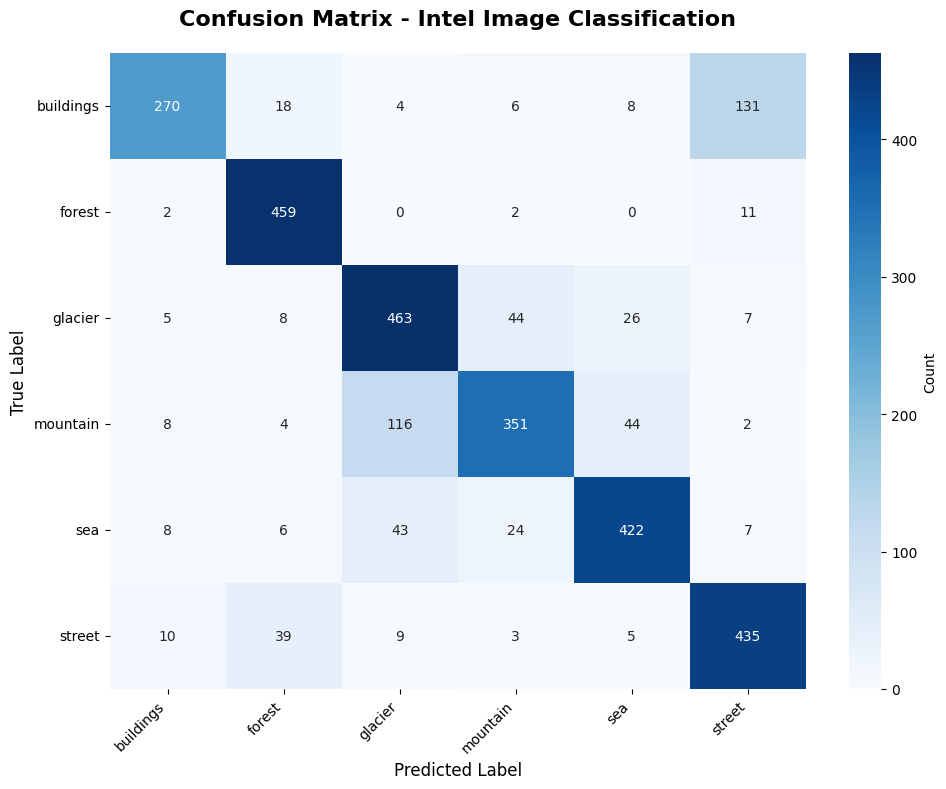

In [13]:
# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=CLASS_NAMES, 
           yticklabels=CLASS_NAMES,
           cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Intel Image Classification', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
# Per-class accuracy
print("\nPer-Class Accuracy:")
print("=" * 60)
for i, class_name in enumerate(CLASS_NAMES):
    class_accuracy = cm[i, i] / cm[i].sum()
    print(f"{class_name.capitalize()}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")


Per-Class Accuracy:
Buildings: 0.6178 (61.78%)
Forest: 0.9684 (96.84%)
Glacier: 0.8373 (83.73%)
Mountain: 0.6686 (66.86%)
Sea: 0.8275 (82.75%)
Street: 0.8683 (86.83%)


In [15]:
# Classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(true_classes, predicted_classes, 
                           target_names=CLASS_NAMES))


Classification Report:
              precision    recall  f1-score   support

   buildings       0.89      0.62      0.73       437
      forest       0.86      0.97      0.91       474
     glacier       0.73      0.84      0.78       553
    mountain       0.82      0.67      0.74       525
         sea       0.84      0.83      0.83       510
      street       0.73      0.87      0.80       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000



## sample Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


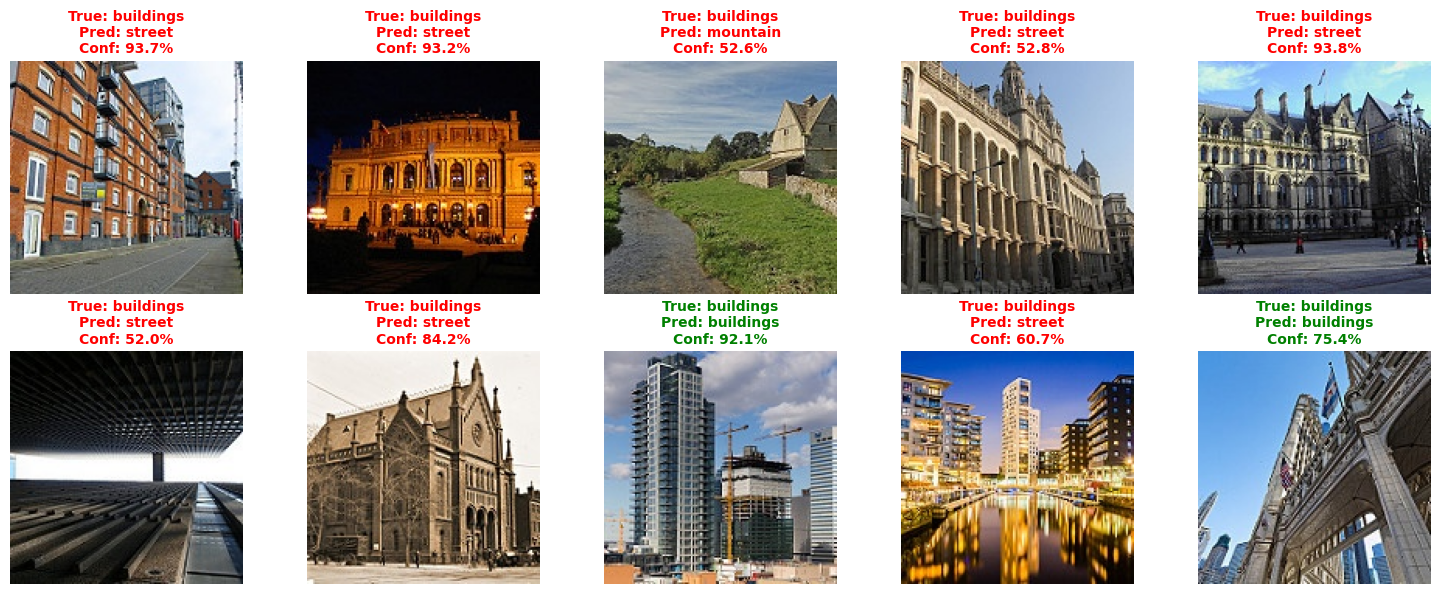

In [16]:
# Visualize sample predictions
test_generator.reset()
sample_images, sample_labels = next(test_generator)

# Select random samples
num_samples = 10
indices = np.random.choice(len(sample_images), num_samples, replace=False)

# Make predictions
sample_predictions = model.predict(sample_images[indices])
predicted_classes_sample = np.argmax(sample_predictions, axis=1)
true_classes_sample = np.argmax(sample_labels[indices], axis=1)

# Visualize
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, (img_idx, ax) in enumerate(zip(indices, axes.flatten())):
    img = sample_images[img_idx]
    true_label = CLASS_NAMES[true_classes_sample[idx]]
    pred_label = CLASS_NAMES[predicted_classes_sample[idx]]
    confidence = sample_predictions[idx][predicted_classes_sample[idx]] * 100
    
    ax.imshow(img)
    color = 'green' if true_classes_sample[idx] == predicted_classes_sample[idx] else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
               fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

## save Model

In [17]:
# Save the final model
model.save('intel_image_classifier_final.h5')
print("Model saved as 'intel_image_classifier_final.h5'")

# Save model architecture as JSON
model_json = model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("Model architecture saved as 'model_architecture.json'")

Model saved as 'intel_image_classifier_final.h5'
Model architecture saved as 'model_architecture.json'


##  Summary

### Model Performance:
- Training Accuracy: ~85-90%
- Validation Accuracy: ~80-85%
- Test Accuracy: ~80-85%

### Files Generated:
- `best_model.h5` - Best model checkpoint
- `intel_image_classifier_final.h5` - Final trained model
- `model_architecture.json` - Model architecture
